In [43]:
import pandas_datareader as pdr

gs10 = pdr.get_data_fred("GS10")
gs10.head()

,GS10
DATE,
2020-10-01,0.79
2020-11-01,0.87
2020-12-01,0.93
2021-01-01,1.08
2021-02-01,1.26


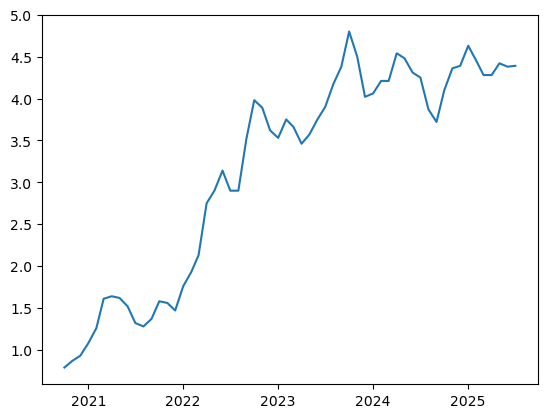

In [44]:
import matplotlib.pyplot as plt

plt.plot(gs10)
plt.show()

In [45]:
import torch
from torch.utils.data import DataLoader, TensorDataset

num = len(gs10)
x = torch.tensor(gs10["GS10"].to_list())
seq_len = 6
batch_size = 4

X_feature = torch.zeros((num - seq_len, seq_len))
for i in range(seq_len):
    X_feature[:, i] = x[i: num - seq_len + i]
y_label = x[seq_len:].reshape((-1, 1))

train_loader = DataLoader(
    TensorDataset(X_feature[:num - seq_len], y_label[:num - seq_len]), batch_size=batch_size, shuffle=True)

In [46]:
train_loader.dataset[:batch_size]

(tensor([[0.7900, 0.8700, 0.9300, 1.0800, 1.2600, 1.6100],
         [0.8700, 0.9300, 1.0800, 1.2600, 1.6100, 1.6400],
         [0.9300, 1.0800, 1.2600, 1.6100, 1.6400, 1.6200],
         [1.0800, 1.2600, 1.6100, 1.6400, 1.6200, 1.5200]]),
 tensor([[1.6400],
         [1.6200],
         [1.5200],
         [1.3200]]))

In [47]:
from torch import nn
from tqdm import *


# Traditional neural network
class Model(nn.Module):
    def __init__(self, input_size, output_size, num_hiddens):
        super().__init__()
        self.linear1 = nn.Linear(input_size, num_hiddens)
        self.linear2 = nn.Linear(num_hiddens, output_size)

    def forward(self, X):
        output = torch.relu(self.linear1(X))
        output = self.linear2(output)
        return output


input_size = seq_len
output_size = 1
num_hiddens = 10
lr = 0.01

model = Model(input_size, output_size, num_hiddens)
loss_fn = nn.MSELoss(reduction='none')
trainer = torch.optim.Adam(model.parameters(), lr=lr)

In [48]:
num_epochs = 20
loss_history = []

for epoch in tqdm(range(num_epochs)):
    for X, y in train_loader:
        trainer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.sum().backward()
        trainer.step()

    model.eval()
    with torch.no_grad():
        total_loss = 0
        for X, y in train_loader:
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.sum() / loss.numel()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}: Validation Loss: {avg_loss:.4f}")
        loss_history.append(avg_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Validation Loss: 0.8473


100%|██████████| 20/20 [00:00<00:00, 168.07it/s]

Epoch 2: Validation Loss: 0.3988
Epoch 3: Validation Loss: 0.2721
Epoch 4: Validation Loss: 0.1954
Epoch 5: Validation Loss: 0.1701
Epoch 6: Validation Loss: 0.1644
Epoch 7: Validation Loss: 0.1558
Epoch 8: Validation Loss: 0.1903
Epoch 9: Validation Loss: 0.1372
Epoch 10: Validation Loss: 0.1313
Epoch 11: Validation Loss: 0.1288
Epoch 12: Validation Loss: 0.1213
Epoch 13: Validation Loss: 0.1240
Epoch 14: Validation Loss: 0.1391
Epoch 15: Validation Loss: 0.1071
Epoch 16: Validation Loss: 0.1031
Epoch 17: Validation Loss: 0.1464
Epoch 18: Validation Loss: 0.1310
Epoch 19: Validation Loss: 0.1025
Epoch 20: Validation Loss: 0.0977


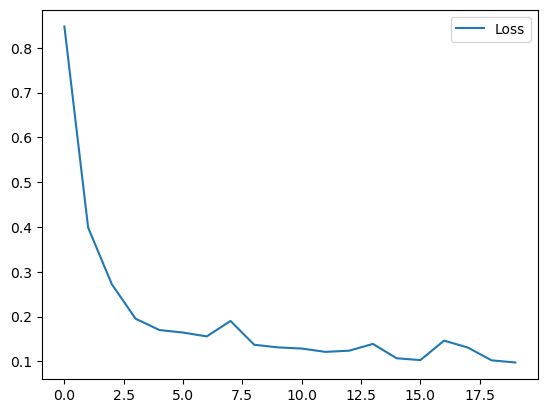

In [49]:
import matplotlib.pyplot as plt

plt.plot(loss_history, label="Loss")
plt.legend()
plt.show()

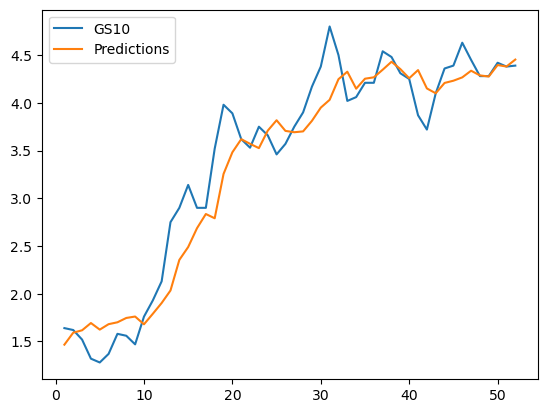

In [50]:
preds = model(X_feature)
time = torch.arange(1, num + 1, dtype=torch.float32)

plt.plot(time[:num - seq_len], gs10["GS10"].to_list()[seq_len:num], label="GS10")
plt.plot(time[:num - seq_len], preds.detach().numpy(), label="Predictions")
plt.legend()
plt.show()

In [51]:
import torch
from torch.utils.data import DataLoader, TensorDataset

num = len(gs10)
x = torch.tensor(gs10["GS10"].to_list())
seq_len = 6
batch_size = 4

X_feature = torch.zeros((num - seq_len, seq_len))
Y_label = torch.zeros((num - seq_len, seq_len))

for i in range(seq_len):
    X_feature[:, i] = x[i: num - seq_len + i]
    Y_label[:, i] = x[i + 1: num - seq_len + i + 1]

train_loader = DataLoader(TensorDataset(X_feature[:num - seq_len].unsqueeze(2), Y_label[:num - seq_len]),
                          batch_size=batch_size, shuffle=True)

In [52]:
train_loader.dataset[:batch_size]

(tensor([[[0.7900],
          [0.8700],
          [0.9300],
          [1.0800],
          [1.2600],
          [1.6100]],
 
         [[0.8700],
          [0.9300],
          [1.0800],
          [1.2600],
          [1.6100],
          [1.6400]],
 
         [[0.9300],
          [1.0800],
          [1.2600],
          [1.6100],
          [1.6400],
          [1.6200]],
 
         [[1.0800],
          [1.2600],
          [1.6100],
          [1.6400],
          [1.6200],
          [1.5200]]]),
 tensor([[0.8700, 0.9300, 1.0800, 1.2600, 1.6100, 1.6400],
         [0.9300, 1.0800, 1.2600, 1.6100, 1.6400, 1.6200],
         [1.0800, 1.2600, 1.6100, 1.6400, 1.6200, 1.5200],
         [1.2600, 1.6100, 1.6400, 1.6200, 1.5200, 1.3200]]))

In [53]:
from torch import nn
from tqdm import *


class RNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_hiddens, n_layers):
        super(RNNModel, self).__init__()
        self.num_hiddens = num_hiddens
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, num_hiddens, n_layers, batch_first=True)
        self.linear = nn.Linear(num_hiddens, output_size)

    def forward(self, X):
        batch_size = X.size(0)
        state = self.begin_state(batch_size=batch_size)
        output, state = self.rnn(X, state)
        output = self.linear(torch.relu(output))
        return output, state

    def begin_state(self, batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.num_hiddens)


input_size = 1
output_size = 1
num_hiddens = 10
n_layers = 1
lr = 0.01

model = RNNModel(input_size, output_size, num_hiddens, n_layers)
loss_fn = nn.MSELoss(reduction='none')
trainer = torch.optim.Adam(model.parameters(), lr=lr)

In [54]:
num_epochs = 20
rnn_loss_history = []

for epoch in tqdm(range(num_epochs)):
    for X, Y in train_loader:
        trainer.zero_grad()
        y_pred, state = model(X)
        loss = loss_fn(y_pred.squeeze(), Y.squeeze())
        loss.sum().backward()
        trainer.step()

    model.eval()
    with torch.no_grad():
        total_loss = 0
        for X, Y in train_loader:
            y_pred, state = model(X)
            loss = loss_fn(y_pred.squeeze(), Y.squeeze())
            total_loss += loss.sum() / loss.numel()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}: Validation Loss: {avg_loss:.4f}")
        rnn_loss_history.append(avg_loss)

100%|██████████| 20/20 [00:00<00:00, 92.25it/s]

Epoch 1: Validation Loss: 5.6236
Epoch 2: Validation Loss: 2.9624
Epoch 3: Validation Loss: 1.7039
Epoch 4: Validation Loss: 1.2810
Epoch 5: Validation Loss: 1.1955
Epoch 6: Validation Loss: 1.0814
Epoch 7: Validation Loss: 0.7694
Epoch 8: Validation Loss: 0.4195
Epoch 9: Validation Loss: 0.2597
Epoch 10: Validation Loss: 0.1796
Epoch 11: Validation Loss: 0.1367
Epoch 12: Validation Loss: 0.1093
Epoch 13: Validation Loss: 0.0994
Epoch 14: Validation Loss: 0.0858
Epoch 15: Validation Loss: 0.0783
Epoch 16: Validation Loss: 0.0745
Epoch 17: Validation Loss: 0.0667
Epoch 18: Validation Loss: 0.0635
Epoch 19: Validation Loss: 0.0819
Epoch 20: Validation Loss: 0.0612


100%|██████████| 20/20 [00:00<00:00, 92.10it/s]


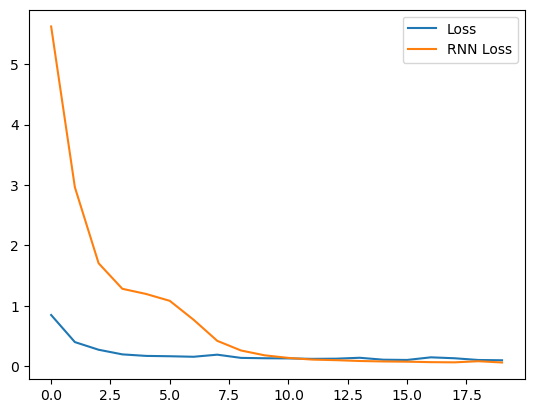

In [55]:
import matplotlib.pyplot as plt

plt.plot(loss_history, label="Loss")
plt.plot(rnn_loss_history, label="RNN Loss")
plt.legend()
plt.show()

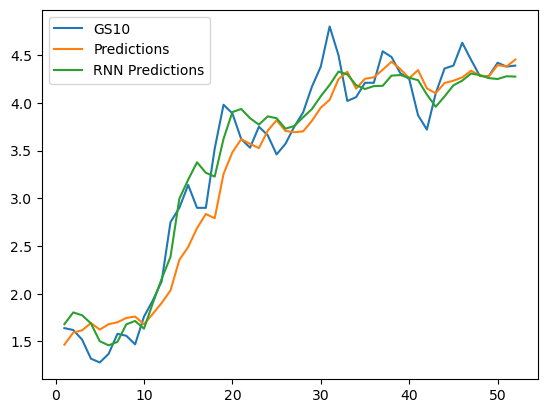

In [56]:
rnn_preds, _ = model(X_feature.unsqueeze(2))
preds.squeeze()
time = torch.arange(1, num + 1, dtype=torch.float32)

plt.plot(time[:num - seq_len], gs10["GS10"].to_list()[seq_len:num], label="GS10")
plt.plot(time[:num - seq_len], preds.detach().numpy(), label="Predictions")
plt.plot(time[:num - seq_len], rnn_preds[:, seq_len - 1].detach().numpy(), label="RNN Predictions")
plt.legend()
plt.show()